#### Jérémy TREMBLAY

# TP6 : Gradient

In [1]:
# Import the libraries that will be used in this notebook.
import numpy as np
import random
from micrograd import nn
from micrograd.engine import Value
from graphviz import Digraph
from sklearn.datasets import make_moons

# Import the pyplot module from matplotlib with the plt alias.
import matplotlib.pyplot as plt

Fix seeds.

In [2]:
np.random.seed(42)
random.seed(42)

## Task 1: Create a first MLP model

**Consigne :** Proposez un premier modèle MLP, composé d’un seul Neurone qui lui prend deux données en entrée. Le modèle sera au final un perceptron. Afficher ensuite les paramètres initialisés de ce modèle. Indications :

* La classe MLP est présente dans le module `micrograd.nn` ;
* Vous pouvez vérifier que le MLP propose une sortie similaire à un Neurone classique.

Vous devriez avoir un modèle composé de 3 paramètres.

Let's initialize the environment first.

In [3]:
model = nn.MLP(2, [1])
print(model)
print(f'Model has: {len(model.parameters())} parameters.')
print(f'These parameters are: {model.parameters()}')

MLP of [Layer of [LinearNeuron(2)]]
Model has: 3 parameters.
These parameters are: [Value(data=0.2788535969157675, grad=0), Value(data=-0.9499784895546661, grad=0), Value(data=0, grad=0)]


The last parameter of this model is the bias.

## Task 2: Define the sigmoïde function

**Consigne :** Définir la fonction d’activation sigmoïde définit telle que : 
`σ(x) = 1 / (1 + exp(-x))`

Indications :  
* elle sera utilisée en sortie du modèle actuel (comme un post-traitement) ;
* attention : il faudra bien affecter la nouvelle valeur à l’attribut data de la sortie du modèle.

In [4]:
def sigmoid(x):
    """
    Applies the sigmoid activation funtcion to the input.

    The sigmoid function is defined as:
    sigmoid(x) = 1 / (1 + exp(-x))

    Parameters:
    - x (Value): The input value.

    Returns:
    Value: The result of applying the sigmoid function to the input value.
    """
    x.data = 1 / (1 + np.exp(-x.data))
    return x

## Task 3: Visualise the tree gradient

**Consigne :** La librairie `micrograd` permet de visualiser l’arbre du gradient. Proposez des données d’entrée au modèle et calculer l’erreur quadrique par rapport à la sortie du modèle.  
Indications :  
* proposez les données d’entrée suivante `[0.888, 0.777]` et une sortie attendue de `[1]` ;
* la fonction `sigmoïd` sera ensuite utilisée en sortie ;
* il faudra propager l’erreur calculée pour calculer le gradient ;
* inspirez-vous du notebook proposé par l’auteur de la librairie pour afficher l’arbre des gradients.

First, let's reuse the functions defined in the notebook to display the graph.

In [5]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Let's use them to compute the quadratic error of the model.

In [6]:
# Create two Value objects, representing inputs for a model.
x = [Value(0.888), Value(0.777)]
output = Value(1) # Target.

# Pass the inputs to the model and obtain the result.
y = model(x)

# Apply the sigmoid function to the output of the model.
sigmoid_y = sigmoid(y)

# Calculate the loss using the mean squared error.
loss = (y - output) ** 2

# Backpropagate the gradient throuhg the computational graph.
loss.backward()

# Visualize the computational graph by drawing the graph of the loss by reusing the previsou functions.
dot = draw_dot(loss)
dot.render('images/gradien_T3') # Save it.

'images\\gradien_T3.svg'

## Task 4: Visualize the graph and answer the questions

**Consigne :** Visualisez le graphe obtenu et proposez des interprétations quant à son contenu. Pouvez-vous expliquer comment est calculer le gradient ?  
Indications :
* toutes les opérations sont présentes (même la différence avec l’attendue) ;
* il faudra bien identifier l’erreur de prédiction ;
* il faudra bien calculer la dérivée de l’erreur utilisée ;
* il faudra également cibler les poids associés aux neurones ;  
*Remarque :* pour calculer la différence avec l’attendue en sortie, `micrograd` propose de multiplier par -1 puis de réaliser la somme entre les deux scalaires.

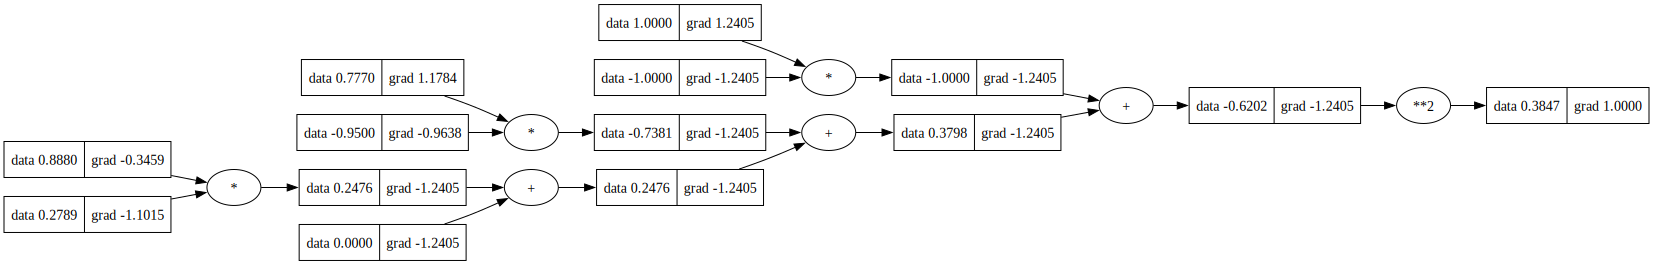

In [7]:
draw_dot(loss)

**Explanation:**
* The graph shows nodes representing the input values, weights, operations (such as addition and multiplication).
* The error is calculated as the squared difference between the model's output and the target output.
* The gradient is computed during backpropagation by traversing the computational graph backward and applying the chain rule to calculate the derivative of the loss with respect to each weight.
* The `binary_activation` function applies a binary activation to the given output value. The function is typically used to convert a continuous output into a binary form, often used in binary classification tasks. If the output.data is greater than 0.5, the result is set to 1; otherwise, it is set to -1.

## Task 5: Update neurals weights

**Consigne :** Proposez maintenant la mise à jour des poids du neurone relativement aux gradients associés à ces poids.

Indications :
* définir une fonction binaire qui permet de définir le label de sortie. La prédiction vaut 1 si la sortie est supérieure à 0.5, sinon elle vaudra 0 ;
* avant de propager toute nouvelle valeur d’erreur (`loss`), il faudra réinitialiser à 0 les gradients de votre modèle.

*Note :* votre modèle doit maintenant être en capacité de prédire la sortie attendue pour les données proposées. Il est possible toutefois qu’il ait fallu propager le gradient plus d’une fois

Let's define our binary activation function:

In [8]:
def binary_activation(output):
    """
    Applies binary activation to the given output.

    The binary activation function sets the output to 1 if it is greater than 0.5, else sets it to 0.

    Parameters:
    - output (Value): The output value to be activated.

    Returns:
    int: The binary activation result, 1 or 0.
    """
    return 1 if output.data > 0.5 else 0

Loss: 0.48481549459663636, Predicted Label: 0
Loss: 0.005736002286273638, Predicted Label: 1
Loss: 0.0029113461593043323, Predicted Label: 1
Loss: 0.0017806927197838165, Predicted Label: 1
Loss: 0.0012076700415506428, Predicted Label: 1
Loss: 0.000875313893788763, Predicted Label: 1
Loss: 0.0006646759739729682, Predicted Label: 1
Loss: 0.0005224809953516149, Predicted Label: 1
Loss: 0.00042182958190553567, Predicted Label: 1
Loss: 0.00034789994770476843, Predicted Label: 1
Loss: 0.00029196061085553376, Predicted Label: 1
Loss: 0.0002485881870155452, Predicted Label: 1
Loss: 0.0002142658256478361, Predicted Label: 1
Loss: 0.0001866299756675344, Predicted Label: 1
Loss: 0.00016404349289149867, Predicted Label: 1
Loss: 0.00014534269570849178, Predicted Label: 1
Loss: 0.00012968171012520732, Predicted Label: 1
Loss: 0.00011643350949372206, Predicted Label: 1
Loss: 0.00010512518593263673, Predicted Label: 1
Loss: 9.539454108797274e-05, Predicted Label: 1
Loss: 8.696032221075381e-05, Predict

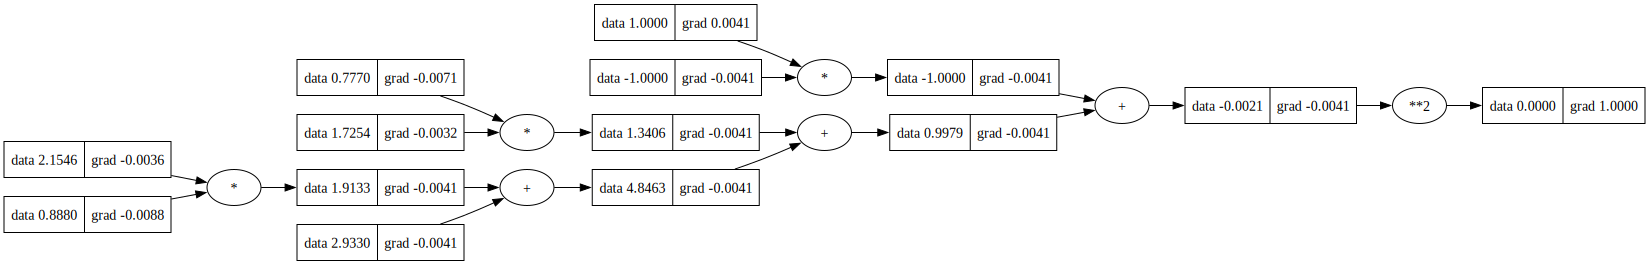

In [9]:
model = nn.MLP(2,[1])

# Iterate until all the propagations will be done for a gradient descend of 100.
for _ in range(100):
    # Compute param value depending on the gradient.
    for param in model.parameters():
        param.data -= param.grad
 
    # Reset gradient.
    model.zero_grad()
    
    # Call the sigmoid function to usit it for the output value.
    y = model([Value(0.888), Value(0.777)])
    sigmoid(y)
    output = Value(1)
    loss = (y - output) ** 2

    # Propagate the update.
    loss.backward()

    # Binary activation function to define the label.
    prediction_label = binary_activation(y)

    # Print the loss and predicted label.
    print(f"Loss: {loss.data}, Predicted Label: {prediction_label}")

draw_dot(loss)

## Task 6: Generate synthetical data with `scikit-learn`

**Consigne :** Générez des données synthétiques à l’aide de la fonction `make_moon` de la librairie `scikit-learn` disponible dans le module `datasets`.
Indications :
* proposez 100 échantillons pour ce dataset ;
* un bruit fixé à 0.1.

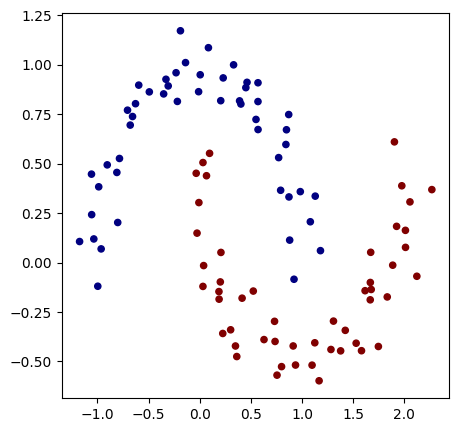

In [10]:
# Generate data.
num_samples = 100
X_data, y_data = make_moons(n_samples=100, noise=0.1)

y_data = y_data*2 - 1
plt.figure(figsize=(5,5))
plt.scatter(X_data[:,0], X_data[:,1], c=y_data, s=20, cmap='jet')
plt.show()

## Taask 7: Compute average error on the model

**Consigne :** Proposez une fonction `model_loss` qui va calculer l’erreur moyenne que peut faire un modèle sur des données d’entrée.
Indications :
* elle prendra 3 paramètres : le modèle, les descripteurs et les labels ;
* une activation sigmoïde en sortie du modèle ;
* une activation binaire pour connaître le label prédit ;
* la fonction d’erreur calculée sera la MSE (l’erreur quadratique moyenne) ;
* la méthode retournera l’erreur moyenne ainsi que le pourcentage de bonnes prédictions (précision) du modèle.

In [11]:
def model_loss(model, descriptors, labels):
    """
    Calculate the mean squared error (MSE) and accuracy of a model on input dtaa.

    Args:
        model: The neural network model.
        descriptors: Input features or descriptors.
        labels: True labels corresponding to the input features.

    Returns:
        tuple: A tuple containing mean squared error (MSE) and accuracy.
    """
    predictions = np.array([sigmoid(model(x)) for x in descriptors])
    binary_predictions = np.array([binary_activation(pred) for pred in predictions])

    mse = [ (yi - y_p) ** 2 for yi, y_p in zip(labels, predictions)] 
    mse_values = sum(mse) / len(mse)
    accuracy = np.mean(binary_predictions == labels)

    return mse_values, accuracy

## Task 8: Create a new MLP model

**Consigne :** Créer un nouveau modèle MLP. Ce modèle sera composé de deux neurones à 2 entrées et un neurone de sortie. Visualisez de nouveau le graphe des gradients obtenu sur des données synthétiques.  
Que pouvez-vous remarquer ?

In [12]:
# Create a new MLP model.
mlp_model = nn.MLP(2, [2, 1])

# Use our synthetic data to call the function.
mse, accuracy = model_loss(mlp_model, X_data, y_data)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'Accuracy: {accuracy}')

Mean Squared Error: Value(data=1.331107388197259, grad=0)
Accuracy: 0.0


## Task 9: Train the new model

Nous allons maintenant entraîner ce modèle MLP sur les nouvelles données. La fonction `model_loss` précédemment créée nous permettra de connaître l’erreur du modèle et sa performance.  
Indications :
* ce modèle sera composé de deux neurones à 2 entrées et un neurone de sortie ;
* l’apprentissage sera fera sur 10 itérations ;
* la mise à jour des poids sera réalisée avec un taux d’apprentissage dégressif relativement au nombre d’itérations. Le taux d’apprentissage sera initialisé à 1 et décroît à hauteur de 10% par itération ;
* à chaque itération, la valeur moyenne d’erreur et la performance du modèle devront être affichée.  
**Note :** le taux d’apprentissage est une variable importante qui permet de spécifier le comportement de la descente de gradient sur les poids du réseau. On parlera ici de descente de gradient stochastique

In [20]:
# Create a new model.
new_model = nn.MLP(2, [2, 1])

# train it on 10 iterations.
for k in range(10):
    new_model.zero_grad()
    # Update learning rate.
    learning_rate = 1.0 - (0.1 * k)
    loss, accuracy = model_loss(new_model, X_data, y_data)

    loss.backward()

    # Use learning rate in the calculation of the gradient.
    for param in new_model.parameters():
        param.data -= learning_rate * param.grad

    print(f"[step {k}] loss {loss.data}, accuracy {accuracy*100}%")

[step 0] loss 1.3589747570145558, accuracy 48.0%
[step 1] loss 1.0195695997263403, accuracy 0.0%
[step 2] loss 0.9613781859857106, accuracy 0.0%
[step 3] loss 0.8892107334652554, accuracy 12.0%
[step 4] loss 0.8325032830081491, accuracy 25.0%
[step 5] loss 0.7989890704905921, accuracy 26.0%
[step 6] loss 0.7766633998342511, accuracy 28.000000000000004%
[step 7] loss 0.7618225258596261, accuracy 28.999999999999996%
[step 8] loss 0.75183431495587, accuracy 28.999999999999996%
[step 9] loss 0.7457727781274578, accuracy 28.999999999999996%


The performance is moderate.

## Task 10: Create a model with more neurals

**Consigne :** Proposez maintenant un nouveau modèle MLP avec 16 neurones cachés. Entraînez-le et observez l’évolution de ses performances.  
Indications :
* cette fois-ci l’apprentissage sera fera sur 100 itérations ;
* la mise à jour des poids sera réalisée avec un taux d’apprentissage dégressif relativement au nombre d’itérations. Le taux d’apprentissage sera initialisé à 1 et décroît à hauteur de 10% par itération ;
* à chaque itération, la valeur moyenne d’erreur et la performance du modèle devront être affichée.

In [23]:
# New MLDP model with 16 neurals.
new_model = nn.MLP(2, [16, 1])

# The rest remains unchanged.
for k in range(100):
    new_model.zero_grad()
    learning_rate = 1.0 - (0.1 * k)
    loss, accuracy = model_loss(new_model, X_data, y_data)

    loss.backward()

    for param in new_model.parameters():
        param.data -= learning_rate * param.grad

    print(f"[step {k}] loss {loss.data:2f}, accuracy {(accuracy*100):2f}%")

[step 0] loss 1.184311, accuracy 0.000000%
[step 1] loss 0.755657, accuracy 16.000000%
[step 2] loss 0.733970, accuracy 24.000000%
[step 3] loss 0.764841, accuracy 23.000000%
[step 4] loss 0.747468, accuracy 25.000000%
[step 5] loss 0.779998, accuracy 22.000000%


C:\Users\jtrem\AppData\Local\Temp\ipykernel_14276\2033772189.py:14: RuntimeWarning: overflow encountered in exp
  x.data = 1 / (1 + np.exp(-x.data))


[step 6] loss 0.745566, accuracy 25.000000%
[step 7] loss 0.774970, accuracy 22.000000%
[step 8] loss 0.754569, accuracy 24.000000%
[step 9] loss 0.769964, accuracy 23.000000%
[step 10] loss 0.754271, accuracy 24.000000%
[step 11] loss 0.754271, accuracy 24.000000%
[step 12] loss 0.749943, accuracy 25.000000%
[step 13] loss 0.727274, accuracy 27.000000%
[step 14] loss 0.690001, accuracy 31.000000%
[step 15] loss 0.787909, accuracy 36.000000%
[step 16] loss 0.941243, accuracy 42.000000%
[step 17] loss 1.190042, accuracy 50.000000%
[step 18] loss 1.802551, accuracy 50.000000%
[step 19] loss 2.000000, accuracy 50.000000%
[step 20] loss 2.000000, accuracy 50.000000%
[step 21] loss 2.000000, accuracy 50.000000%
[step 22] loss 2.000000, accuracy 50.000000%
[step 23] loss 2.000000, accuracy 50.000000%
[step 24] loss 2.000000, accuracy 50.000000%
[step 25] loss 2.000000, accuracy 50.000000%
[step 26] loss 2.000000, accuracy 50.000000%
[step 27] loss 2.000000, accuracy 50.000000%
[step 28] loss

The performances are now improved compare to the previsou model, probably because there are more neurals.